# Frequecy domain image processing
It is possible to take the Fourier transform of 2D signals just like 1D signals and analyse them in the frequency domain.

In 1D we can show that the Fourier transform of a pulse corresponds to the *sinc* function which has a peak at $0$ Hertz. The equivalent signal in 2D is a rectangle.

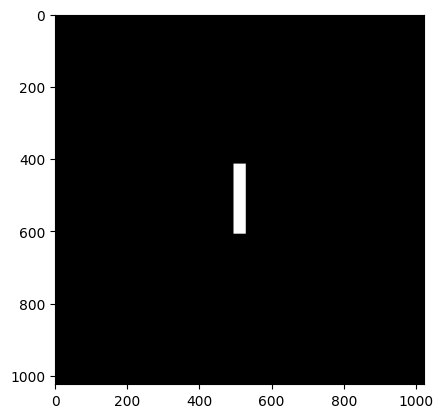

In [9]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as img
from tqdm import tqdm

image = img.imread("img/rectangle.tif")
plt.imshow(image, cmap='gray')
plt.show()

### A. Implementing a DFT Algorithm (No FFT)
The DFT of an image $f(x,y)$ is given by

$$ F(u,v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x,y) e^{-j2\pi(ux/M + vy/N)} $$

Let's code up this equation from scratch to see how it can be implemented. We shall also compute the magnitude spectrum for visualisation. But first, we shall resize the image to a very small size of $28 \times 28$ pixels so that the DFT computation does not take forever.

Without using the FFT algorithm, the code in the cells below would need to perform at least $(1024 \times 1024)^2$ operations to complete the DFT. This is too much computation to complete in reasonable time. It would take hours to finish!

In [18]:
image2 = cv.resize(image, (28, 28), interpolation=cv.INTER_CUBIC)
# plt.imshow(image2)

In [79]:
def dft2d(image):
    """
    Perform the 2D Discrete Fourier Transform (DFT) on a grayscale image.
    :param image: 2D numpy array (grayscale image)
    :return: 2D numpy array (DFT of the image)
    """
    M, N = image.shape  # Image dimensions
    dft = np.zeros((M, N), dtype=complex)
    
    for u in tqdm(range(M)):
        for v in range(N):
            sum_val = 0
            for x in range(M):
                for y in range(N):
                    angle = -2j * np.pi * ((u * x / M) + (v * y / N))
                    sum_val += image[x, y] * np.exp(angle)
            dft[u, v] = sum_val
    
    return dft

def mag_spectrum(dft):
    """
    Compute the magnitude spectrum of the DFT.
    :param dft: 2D numpy array (DFT of the image)
    :return: 2D numpy array (magnitude spectrum)
    """
    return np.log(1 + np.abs(dft))


def magnitude_spectrum_no_log(dft):
    """
    Compute the magnitude spectrum of the DFT without logarithmic scaling.
    :param dft: 2D numpy array (DFT of the image)
    :return: 2D numpy array (magnitude spectrum)
    """
    return np.abs(dft)


def compute_mag_spectrum(dft):
    return np.log(np.abs(dft + 1))


def center_image(image):
    """
    Multiply the image by (-1)^(x+y) to center the zero-frequency component.
    :param image: 2D numpy array (grayscale image)
    :return: 2D numpy array (modified image)
    """
    M, N = image.shape
    centered_image = np.zeros_like(image, dtype=float)
    
    for x in range(M):
        for y in range(N):
            centered_image[x, y] = image[x, y] * (-1) ** (x + y)
    
    return centered_image

In [52]:
centred = center_image(image2)

In [48]:
dft = dft2d(image2)
mag = mag_spectrum(dft)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  8.45it/s]


Before we plot the image, let's confirm that the result we get from our code is the same as what we get when we use the FFT implementation in a library.

In [49]:
fft_dft = np.fft.fft2(image2)
np.allclose(dft, fft_dft)

True

Let's also do the same for the centred image -  the image that we multiplied by $(-1)^{x+y}$ before computing its DFT. The centring is done using the function `center_image`.

In [51]:
dft = dft2d(centred)
mag = mag_spectrum(dft)

fft_dft = np.fft.fft2(centred)
np.allclose(dft, fft_dft)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00,  9.44it/s]


True

So, our implementation is good enough. We don't need to use our own implementation going forward because it is slow. You have already looked "under the hood" and seen how the DFT can be implemented. In practice, the FFT algorithm is used for its computation. We shall proceed to work with the image in its original size of $1024 \times 1024$.


### B. DFT Computation using FFT
The code cell below is a reproduction of what you see in _figure 4.23_ of the course textbook (Gonzalez & Woods, 4th edition).

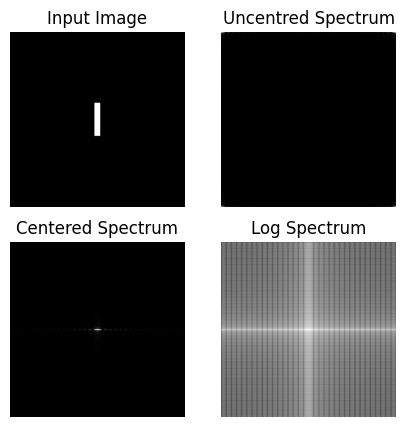

In [85]:
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)

no_log_spectrum_b4_shift = magnitude_spectrum_no_log(f)
no_log_centered_spectrum = magnitude_spectrum_no_log(fshift)
log_centred_spectrum = compute_mag_spectrum(fshift)

plt.figure(figsize=(5,5))
plt.subplot(221),plt.imshow(image, cmap = 'gray'), plt.title('Input Image'), plt.axis('off')
plt.subplot(222),plt.imshow(no_log_spectrum_b4_shift, cmap = 'gray'),plt.title('Uncentred Spectrum'),plt.axis('off')
plt.subplot(223),plt.imshow(no_log_centered_spectrum, cmap = 'gray'),plt.title('Centered Spectrum'),plt.axis('off')
plt.subplot(224),plt.imshow(log_centred_spectrum, cmap = 'gray'),plt.title('Log Spectrum'),plt.axis('off')
plt.show()

## C. Frequency components in images
In images, low frequency content corresponds to areas of gradual variation. For example a wall in a room would correspond to low frequency content. Edges and areas of rapid variation are high frequency components.

If there are repeated structures in the image, these emerge as a strong frequency component. The Fourier transform also captures the direction of the variation

In [3]:
I1_low = np.zeros((64,64))
I2_low = np.zeros((64,64))

for i in range(0, I1_low.shape[0], 8):
    I1_low[:,i] = np.ones(I1_low.shape[0])
    I2_low[i,:] = np.ones(I1_low.shape[0]) 

I1_high = np.zeros((64,64))
I2_high = np.zeros((64,64))

for i in range(0, I1_high.shape[0], 4):
    I1_high[:,i] = np.ones(I1_high.shape[0])
    I2_high[i, :] = np.ones(I1_high.shape[0]) 

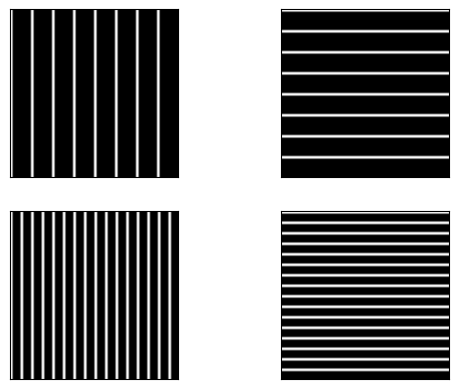

In [4]:
plt.subplot(221)
plt.imshow(I1_low, cmap = 'gray')
plt.xticks([])
plt.yticks([])

plt.subplot(222)
plt.imshow(I2_low, cmap = 'gray')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(I1_high, cmap = 'gray')
plt.xticks([])
plt.yticks([])

plt.subplot(224)
plt.imshow(I2_high, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

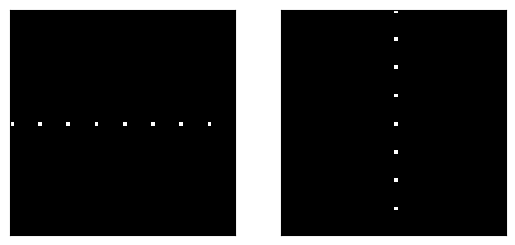

In [5]:
f1_low = np.fft.fft2(I1_low)
f1_low_shift = np.fft.fftshift(f1_low)

f2_low = np.fft.fft2(I2_low)
f2_low_shift = np.fft.fftshift(f2_low)

magnitude_spectrum1 = 20*np.log(np.abs(f1_low_shift + 1e-8))
magnitude_spectrum2 = 20*np.log(np.abs(f2_low_shift + 1e-8))

plt.subplot(121)
plt.imshow(magnitude_spectrum1, cmap = 'gray')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(magnitude_spectrum2, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

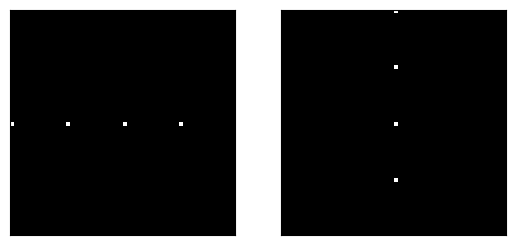

In [6]:
f1_high = np.fft.fft2(I1_high)
f1_high_shift = np.fft.fftshift(f1_high)

f2_high = np.fft.fft2(I2_high)
f2_high_shift = np.fft.fftshift(f2_high)

magnitude_spectrum1 = 20*np.log(np.abs(f1_high_shift + 1e-8))
magnitude_spectrum2 = 20*np.log(np.abs(f2_high_shift + 1e-8))

plt.subplot(121)
plt.imshow(magnitude_spectrum1, cmap = 'gray')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(magnitude_spectrum2, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.show()

# D. Effect of rotation
Let us examine the Fourier transform of a rotated image. 

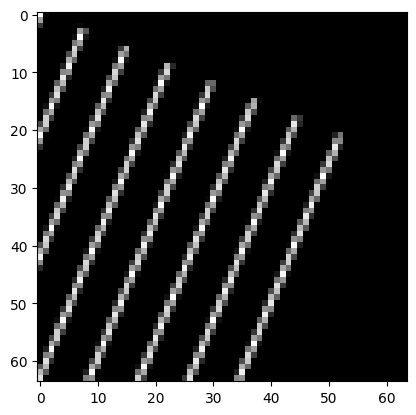

In [7]:
# rotation
theta = np.pi / 8
M = np.float32([[np.cos(theta),-np.sin(theta),0],[np.sin(theta),np.cos(theta),0]])
dst = cv.warpAffine(I1_low, M, (I1_low.shape[0], I1_low.shape[0]))

plt.imshow(dst, cmap='gray')
plt.show()

([], [])

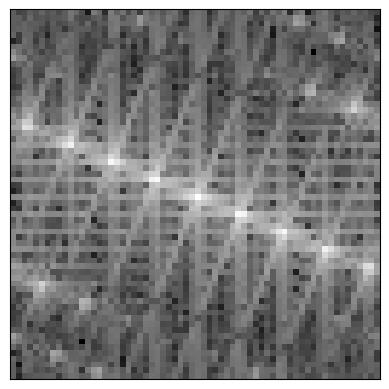

In [8]:
f_rotated= np.fft.fft2(dst)
f_rotated_shift = np.fft.fftshift(f_rotated)

magnitude_spectrum_rotated = 20*np.log(np.abs(f_rotated_shift + 1e-8))

plt.imshow(magnitude_spectrum_rotated, cmap = 'gray')
plt.xticks([])
plt.yticks([])

Notice that the DFT spectrum is rotated by the same angle by which the image was also rotated before being transformed. This is the _rotation_ property of the DFT, which is captured by the following equation:
$$ f(r, \theta + \theta_0) \Leftrightarrow F(\omega, \psi + \theta_0) $$

## E. Frequency domain filtering
Frequency domain filtering is achieved by taking the inverse Fourier transform of the product of the image Fourier transform and that of the desired filter.

That is

\begin{equation}
g(x,y) = \mathrm{Real}\{ \mathcal{F}^{-1}[H(u,v)F(u,v)]\}
\end{equation}

The sections below follow [this link](https://stackoverflow.com/questions/66935821/how-to-apply-a-lpf-and-hpf-to-a-fft-fourier-transform).

## E.1) Ideal Low Pass Filter
The ideal low pass filter is given by

\begin{equation}
H(u,v)=
\begin{cases}
1 & D(u,v) \leq D_0\\
0 & D(u,v) > D_0
\end{cases}
\end{equation}

In [149]:
def make_ilpf(image, radius):
    
    mask = np.zeros_like(image)

    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2 
    cv.circle(mask, (cx,cy), radius, (255,255,255), -1)[0]
    
    return mask

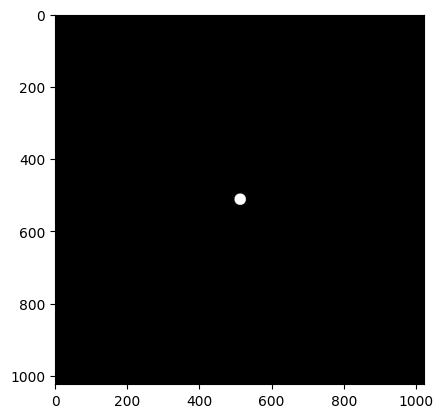

In [150]:
D0 = 16

image = img.imread("img/rectangle.tif")
mask = make_ilpf(image, D0)

plt.imshow(mask, cmap='gray')
plt.show()

In [87]:
# Take DFT of rectangle and multiply with ILPF
f_rec = np.fft.fft2(image)
f_rec_shift = np.fft.fftshift(f_rec)

filtered = np.multiply(f_rec_shift, mask) / 255

shift_filtered = np.fft.ifftshift(filtered)
img_filtered = np.fft.ifft2(shift_filtered, axes=(0,1))

img_filtered[0,0]

(2.574367388341316-1.0321604682062002e-16j)

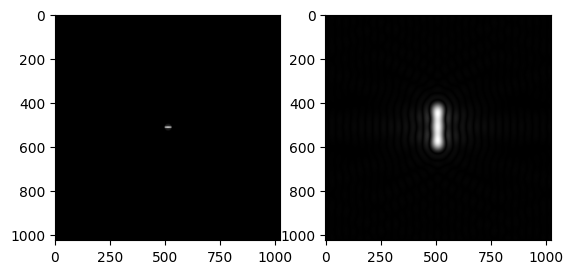

In [152]:
# get the magnitude
filtered_mag = np.abs(shift_filtered).clip(0,255).astype(np.uint8)


plt.subplot(121)
plt.imshow(np.abs(filtered), cmap='gray')

plt.subplot(122)
plt.imshow(np.abs(img_filtered), cmap='gray')
plt.show()

What we see here is that the image has generally been blurred by the filtered. But notice that the filtered image has very visible _ringing_ artefacts surrounding the main blurred rectangle. The ringing is the observable "echoing" of the main object that dampens as we move away from the object itself. It results from the ringing propertis of ILPFs. The main lobe of the ILPF transfer function is responsible for blurring the image while the smaller lobes bring about the ringing.

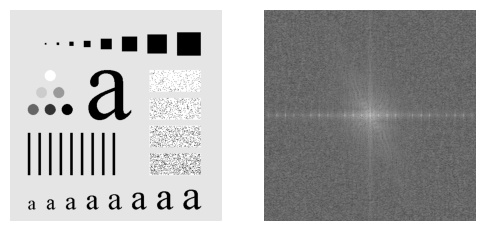

In [109]:
image = img.imread("img/test-pattern.tif")
mask = make_ilpf(image, 10)

dft = np.fft.fftshift(np.fft.fft2(image))
filtered_dft = np.multiply(dft, mask) / 255

filtered_img = np.fft.ifftshift(np.fft.ifft2(filtered_dft, axes=(0, 1)))

plt.figure(figsize=(6,3))
plt.subplot(121), plt.imshow(image, 'gray'), plt.axis('off')
plt.subplot(122), plt.imshow(compute_mag_spectrum(dft), 'gray'), plt.axis('off')
plt.show()

### E.2) Gaussian Low-pass Filter
Let's create a Gaussian low-passs filter with a certain _cutoff frequency_ and then apply it to an image.

In [153]:
def gaussian_low_pass_filter(shape, cutoff):
    """
    Create a Gaussian low-pass filter in the frequency domain.
    :param shape: Tuple (M, N) representing the size of the filter
    :param cutoff: Cutoff frequency (sigma for the Gaussian)
    :return: 2D numpy array (Gaussian low-pass filter)
    """
    M, N = shape
    center_x, center_y = M // 2, N // 2
    filter_array = np.zeros((M, N), dtype=float)

    for x in range(M):
        for y in range(N):
            distance = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
            filter_array[x, y] = np.exp(- (distance ** 2) / (2 * (cutoff ** 2)))

    return filter_array

def filter_image_with_gaussian(image_array, cutoff):
    """
    Apply a Gaussian low-pass filter to an image in the frequency domain.
    :param image_array: 2D numpy array (grayscale image)
    :param cutoff: Cutoff frequency for the Gaussian filter
    :return: 2D numpy array (filtered image)
    """
    # Step 1: Center the image
    centered_image = image_array * (-1) ** (np.indices(image_array.shape).sum(axis=0))

    # Step 2: Perform the Fourier Transform
    dft_image = np.fft.fft2(centered_image)

    # Step 3: Create the Gaussian low-pass filter
    gaussian_filter = gaussian_low_pass_filter(image_array.shape, cutoff)

    # Step 4: Apply the filter in the frequency domain
    filtered_dft = dft_image * gaussian_filter

    # Step 5: Perform the inverse Fourier Transform
    filtered_image = np.fft.ifft2(filtered_dft).real

    # Step 6: Uncenter the image
    uncentered_image = filtered_image * (-1) ** (np.indices(image_array.shape).sum(axis=0))

    return uncentered_image

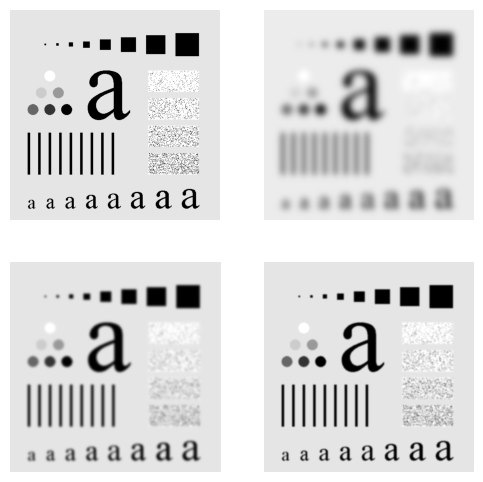

In [154]:
image = img.imread("img/test-pattern.tif")

filt_10 = filter_image_with_gaussian(image, 10)
filt_30 = filter_image_with_gaussian(image, 30)
filt_60 = filter_image_with_gaussian(image, 60)

plt.figure(figsize=(6, 6))
plt.subplot(221), plt.imshow(image, 'gray'), plt.axis('off')
plt.subplot(222), plt.imshow(filt_10, 'gray'), plt.axis('off')
plt.subplot(223), plt.imshow(filt_30, 'gray'), plt.axis('off')
plt.subplot(224), plt.imshow(filt_60, 'gray'), plt.axis('off')
plt.show()

## E.3) Ideal High Pass Filter
The ideal high pass filter is given by

\begin{equation}
H(u,v)=
\begin{cases}
0 & D(u,v) \leq D_0\\
1 & D(u,v) > D_0
\end{cases}
\end{equation}

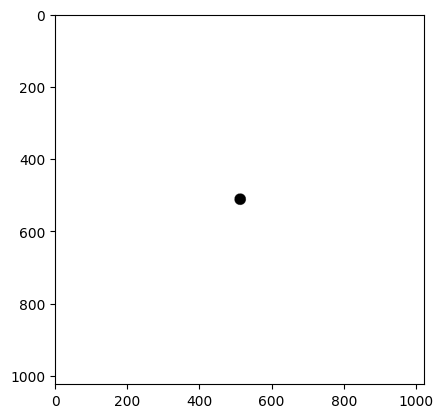

In [12]:
# create the IHPF
mask = 255 - mask

plt.imshow(mask, cmap='gray')
plt.show()

In [13]:
# apply to image
filtered = np.multiply(f_rec_shift, mask) / 255

shift_filtered = np.fft.ifftshift(filtered)
img_filtered = np.fft.ifft2(shift_filtered, axes=(0,1))

img_filtered[0,0]

(-2.5743673883413085+4.397524011601206e-16j)

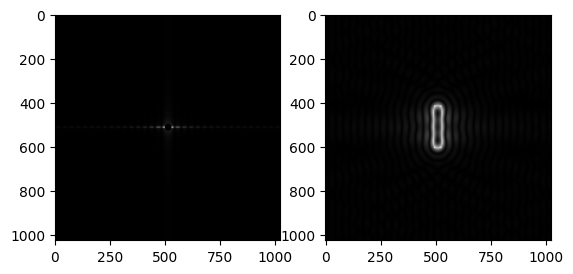

In [14]:
# get the magnitude
filtered_mag = np.abs(shift_filtered).clip(0,255).astype(np.uint8)


plt.subplot(121)
plt.imshow(np.abs(filtered), cmap='gray')

plt.subplot(122)
plt.imshow(np.abs(img_filtered), cmap='gray')
plt.show()

As in the case of the ideal low-pass filter, notice that the filtered image has very visible _ringing_ artefacts resulting from the ringing propertis of IHPFs. We already said that the main lobe of the IHPF transfer function is responsible for highlighting the edges (as seen in the filtered image) while the smaller lobes bring about the ringing.

### E.4) Laplacian High-pass Filter
The centred Laplacian filter in frequency domain is defined by the equation

\begin{align}
     H(u,v) &= -4\pi^2 \Bigl[ (u - P/2)^2 + (v - Q/2)^2 \Bigr] \\
     &= -4\pi^2D^2(u,v)
\end{align}

where $D(u,v)$ is the distance from some point $(u,v)$ in the DFT to the centre of the frequency rectangle (centre of the centred DFT). 

The Laplacian of an image $f(x,y)$ is then computed as:
$$ \nabla^2 f(x,y) = \mathscr{F}^{-1} \Bigl[ H(u,v) F(u,v) \Bigr] $$
and the sharpened image as
$$ g(x,y) = f(x,y) + c\Bigl[ \nabla^2 f(x,y) \Bigr] $$
where $c$ is $-1$ because $H(u,v)$ is negative.

In [214]:
def laplacian_filter(shape):
    """
    Create a Laplacian filter in the frequency domain.
    :param shape: Tuple (M, N) representing the size of the filter
    :return: 2D numpy array (Laplacian filter in frequency domain)
    """
    M, N = shape
    center_x, center_y = M // 2, N // 2
    filter_array = np.zeros((M, N), dtype=float)

    for u in range(M):
        for v in range(N):
            # Compute distances from the center
            du = u - center_x
            dv = v - center_y
            distance_squared = du**2 + dv**2
            # Laplacian in frequency domain: H(u, v) = -4π²(D²)
            filter_array[u, v] = -4 * (np.pi**2) * distance_squared

    return filter_array

def filter_image_with_laplacian(image_array):
    """
    Apply a Laplacian filter to an image in the frequency domain.
    :param image_array: 2D numpy array (grayscale image)
    :return: 2D numpy array (filtered image)
    """
    # Step 1: Center the image
    centered_image = image_array * (-1) ** (np.indices(image_array.shape).sum(axis=0))

    # Step 2: Perform the Fourier Transform
    dft_image = np.fft.fft2(centered_image)

    # Step 3: Create the Laplacian filter
    laplacian = laplacian_filter(image_array.shape)

    # Step 4: Apply the filter in the frequency domain
    filtered_dft = dft_image * laplacian

    # Step 5: Perform the inverse Fourier Transform
    filtered_image = np.fft.ifft2(filtered_dft).real

    # Step 6: Uncenter the image
    uncentered_image = filtered_image * (-1) ** (np.indices(image_array.shape).sum(axis=0))

    # Step 7: Scale the image so that its maximum value is 255
    scaled_image = (uncentered_image / uncentered_image.max()) * 255.0

    # Step 8: Clip the image's values to the range  [0, 255]
    clipped_image = np.clip(scaled_image, 0, 255).astype(np.uint8)

    # Step 9: Sharpen the image
    sharpened_image = np.clip(image_array.astype(np.float32) - clipped_image, a_min=0, a_max=None)
    sharpened_image = np.clip(sharpened_image, 0, None).astype(np.uint8)

    return sharpened_image

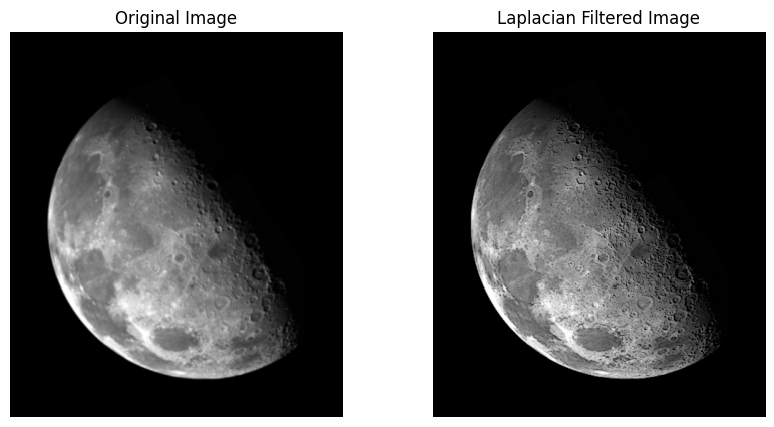

In [216]:
image = img.imread("img/blurry-moon.tif")
sharp = filter_image_with_laplacian(image)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(image, 'gray'), plt.axis('off'), plt.title('Original Image')
plt.subplot(122), plt.imshow(sharp, 'gray'), plt.axis('off'), plt.title('Laplacian Filtered Image')
plt.show()